In [47]:
!python --version

Python 3.10.12


In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.0 MB/s eta 0:00:00


# Import Libraries

In [ ]:
import os
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2 as cv
from PIL import Image

from rich import print
from rich.table import Table

In [ ]:
import seaborn as sns

sns.set_style("darkgrid", {"grid.color": ".4", "grid.linestyle": ":"})

# Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# number of parameters

In [ ]:
def num_trainable_params(model):
    nums = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return format(nums, ',')

# Dataset

## copy & extract dataset

In [ ]:
!tar -xzf '/content/drive/MyDrive/Datasets/UTKFace/UTKFace.tar.gz' -C '/content/'


## EDA

### show random image in dataset

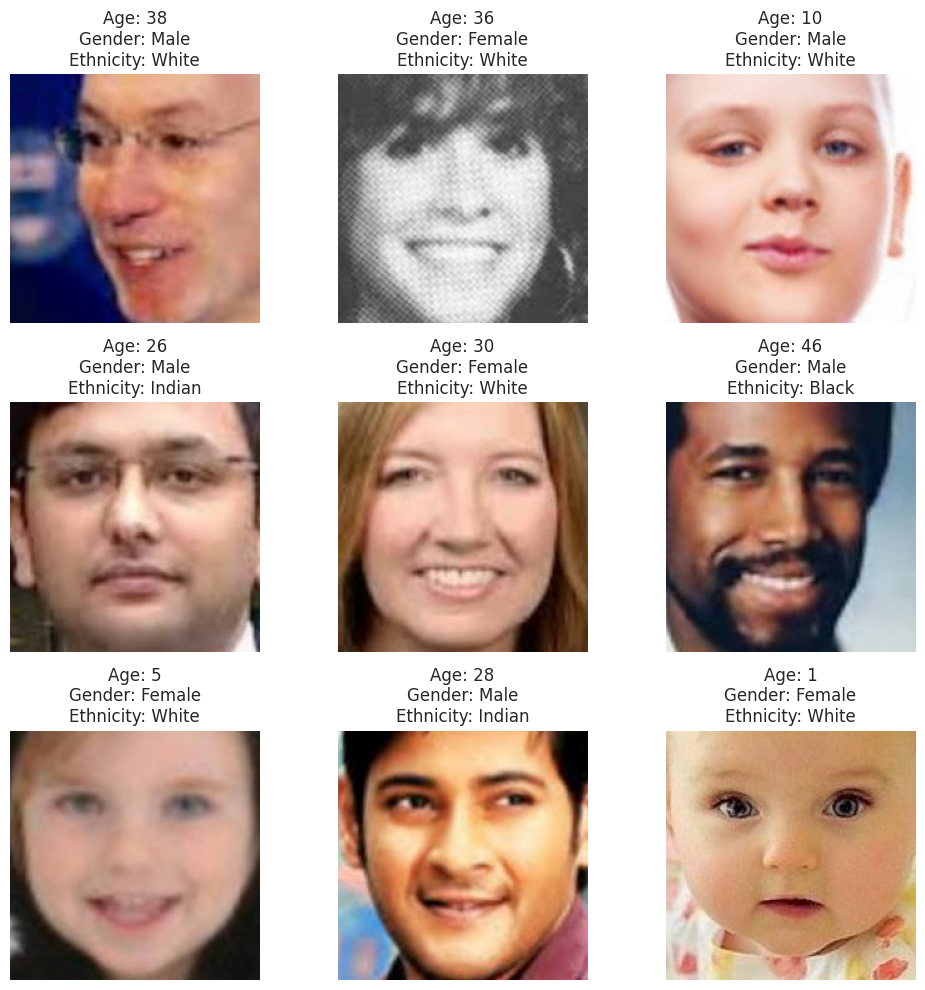

In [ ]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = '/content/UTKFace/'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


### create csv file

In [ ]:
def create_dataframe(path_dataset: str):
    image_files = os.listdir(path_dataset)
    list_files = []

    for idx, image_file in enumerate(image_files):
        age, gender, ethnicity = image_file.split('_')[:3]

        if len(image_file.split('_')) < 4:
            continue

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        if int(age) > 90:
            continue

        list_files.append([image_file, int(age), gender, ethnicity])

    return list_files


ls_files = create_dataframe('/content/UTKFace/')

df = pd.DataFrame(ls_files,
                  columns=['image_name', 'age', 'gender', 'ethnicity'])

df.to_csv('/content/utkface.csv', index=False)


In [ ]:
df

,image_name,age,gender,ethnicity
0,26_1_3_20170104232413655.jpg.chip.jpg,26,Female,Indian
1,2_0_4_20161221195155711.jpg.chip.jpg,2,Male,Others
2,11_1_2_20170104005111615.jpg.chip.jpg,11,Female,Asian
3,8_1_0_20170109204933562.jpg.chip.jpg,8,Female,White
4,28_0_4_20170109140345949.jpg.chip.jpg,28,Male,Others
...,...,...,...,...
23613,26_1_3_20170119193136450.jpg.chip.jpg,26,Female,Indian
23614,50_0_0_20170117160624326.jpg.chip.jpg,50,Male,White
23615,32_0_2_20170116184944206.jpg.chip.jpg,32,Male,Asian
23616,24_1_3_20170119171104872.jpg.chip.jpg,24,Female,Indian


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23618 entries, 0 to 23617
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  23618 non-null  object
 1   age         23618 non-null  int64 
 2   gender      23618 non-null  object
 3   ethnicity   23618 non-null  object
dtypes: int64(1), object(3)
memory usage: 738.2+ KB


In [ ]:
df['age'] = df['age'].astype('int32')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23618 entries, 0 to 23617
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  23618 non-null  object
 1   age         23618 non-null  int32 
 2   gender      23618 non-null  object
 3   ethnicity   23618 non-null  object
dtypes: int32(1), object(3)
memory usage: 645.9+ KB


In [ ]:
df.describe()

,age
count,23618.000000
mean,33.058557
std,19.512032
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,90.000000


### Plot histogram for age

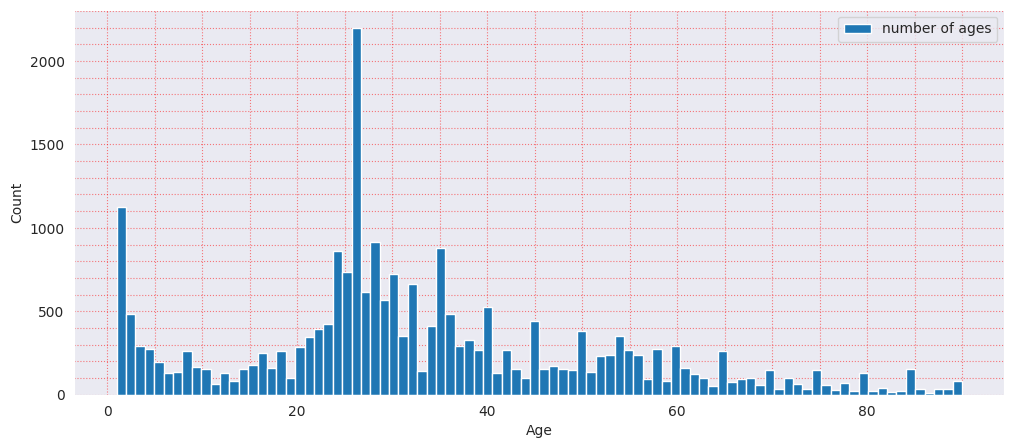

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(df.age, bins=len(df.age.unique()), label='number of ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(which='both', alpha=0.5, color='r')
plt.minorticks_on()
plt.legend()
plt.show()

In [ ]:
df.age.value_counts()

26    2197
1     1123
28     918
35     880
24     859
      ... 
84      24
79      23
81      22
83      18
87      10
Name: age, Length: 90, dtype: int64

In [ ]:
df.age.describe()

count    23618.000000
mean        33.058557
std         19.512032
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max         90.000000
Name: age, dtype: float64

### Plot histogram for gender

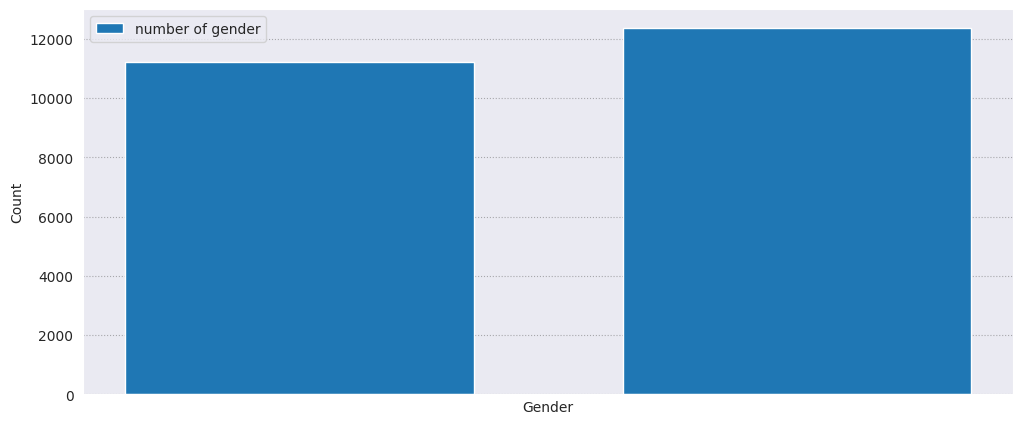

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(df.gender, bins=len(df.gender.unique()), label='number of gender',
         rwidth=0.7)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(which='major', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
df.gender.value_counts()

Male      12379
Female    11239
Name: gender, dtype: int64

### Plot histogram for ethnicity

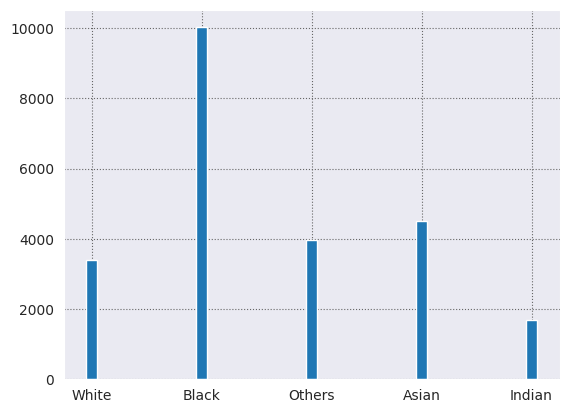

In [ ]:
_values, bin_edges, _rectangles = plt.hist(df.ethnicity, bins=len(df.ethnicity.unique()), rwidth=0.1)

plt.xticks((bin_edges[:-1] + bin_edges[1:])/2,
           ['White', 'Black', 'Others', 'Asian', 'Indian']);

In [ ]:
df.ethnicity.value_counts()

White     10025
Black      4519
Indian     3971
Asian      3411
Others     1692
Name: ethnicity, dtype: int64

## cross-tabulation of gender and ethnicity

In [ ]:
pd.crosstab(index=df.gender, columns=df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1839,2202,1711,932,4555
Male,1572,2317,2260,760,5470


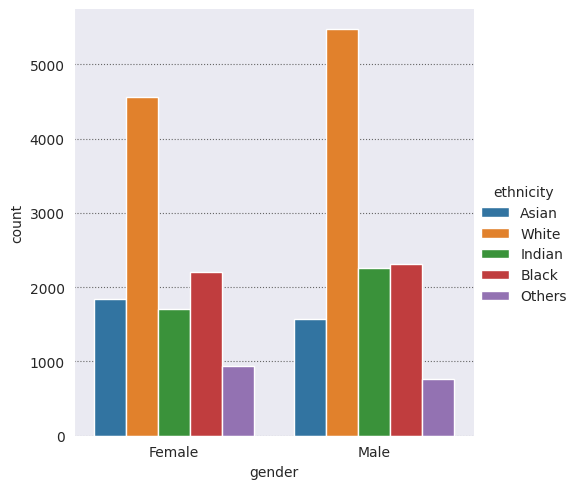

In [ ]:
sns.catplot(data=df, x='gender', hue='ethnicity', kind='count')

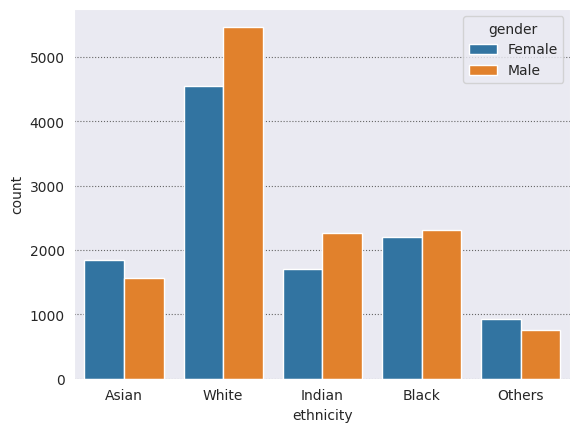

In [ ]:
sns.countplot(data=df, x='ethnicity', hue='gender');

### violin plots and box plots for age, separately for men and women

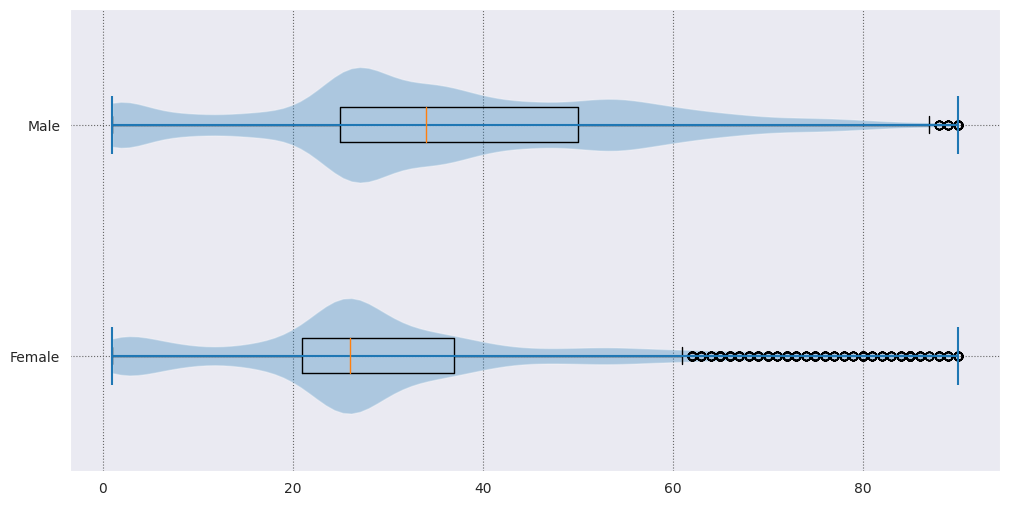

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False,
            labels=df.gender.unique())
plt.violinplot([df.age[df.gender == cat] for cat in df.gender.unique()], vert=False);

### violin plots and box plots for age, separately for each ethnicity

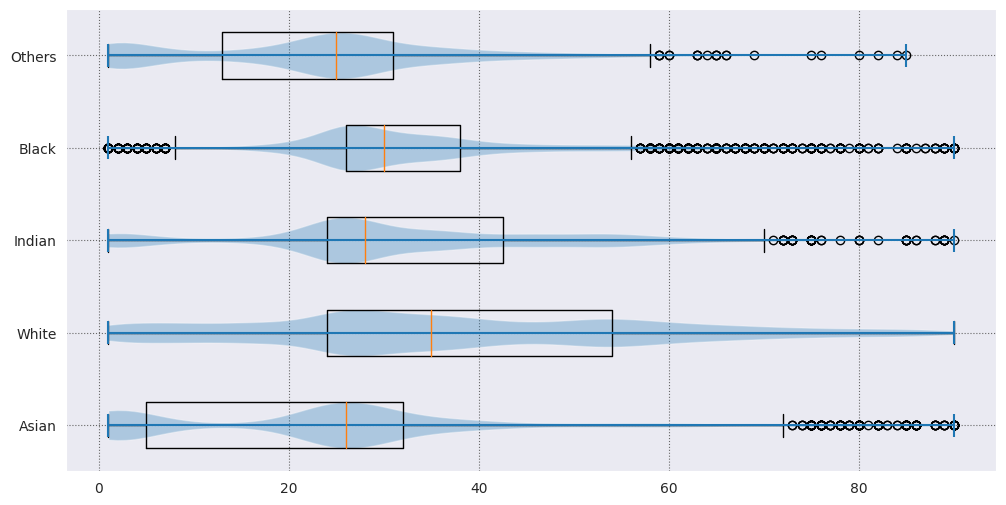

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()],
            vert=False, labels=df.ethnicity.unique())
plt.violinplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()],
               vert=False);

## Split datasets

In [ ]:
df_train, temp = train_test_split(df, test_size=0.3, stratify=df.age, random_state=42)
df_test, df_valid = train_test_split(temp, test_size=0.5, stratify=temp.age, random_state=42)

df_train.shape, df_test.shape, df_valid.shape

((16532, 4), (3543, 4), (3543, 4))

### distributions of the training, validation, and test sets

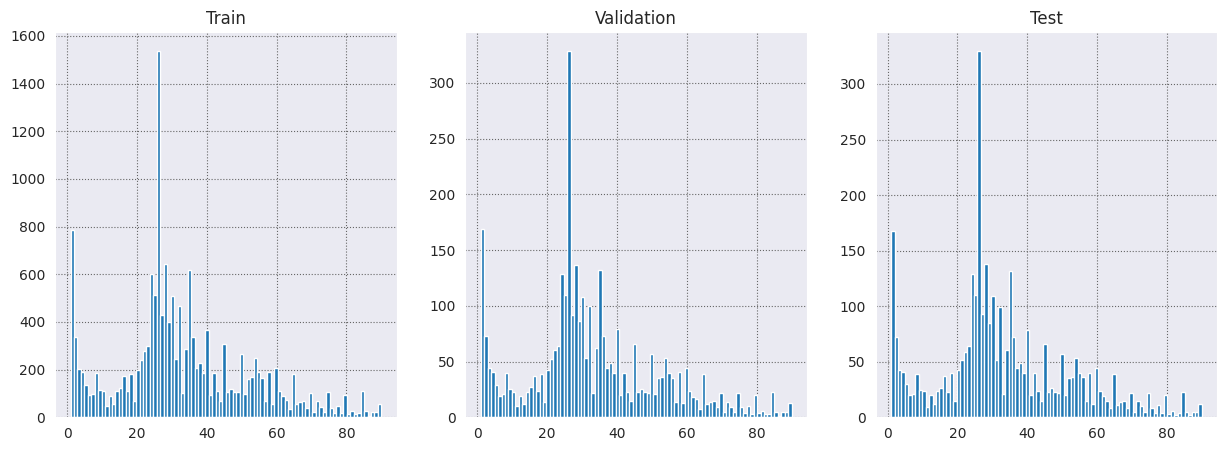

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

## transformation and data augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

## Custome Dataset

In [ ]:
class UTKDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        self.gender_dict = {'Male': 0, 'Female': 1}
        self.ethnicity_dict = {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3,
                               'Others': 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx, :]

        img_name = sample.image_name
        img = Image.open(os.path.join(self.root_dir, img_name))

        age = torch.tensor([sample.age], dtype=torch.float32)
        gender = torch.tensor(self.gender_dict[sample.gender], dtype=torch.int32)
        ethnicity = torch.tensor(self.ethnicity_dict[sample.ethnicity],
                                 dtype=torch.int32)

        img = self.transform(img)

        return img, age

In [ ]:
dataset = UTKDataset(root_dir='/content/UTKFace',
                          csv_file='/content/valid_set.csv',
                          transform=test_transform)

dataset.data, len(dataset)
dataset[50][1]

tensor([23.])

In [ ]:
dataset_dir = '/content/UTKFace'  # Dataset directory path

train_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/train_set.csv',
                       transform=train_transform)

valid_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/valid_set.csv',
                       transform=test_transform)

test_set = UTKDataset(root_dir=dataset_dir, csv_file='/content/test_set.csv',
                      transform=test_transform)

## DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

In [ ]:
img, age = next(iter(train_loader))
img.shape, age.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 1]))

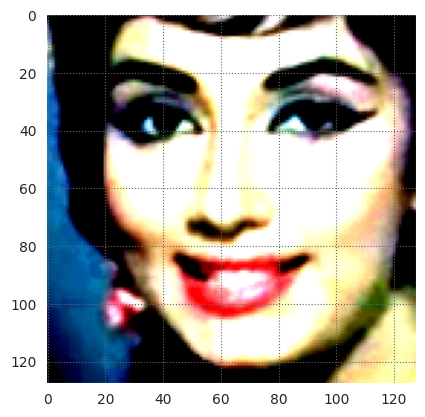

In [ ]:
plt.imshow(img[12].permute(1, 2, 0))

# Model

In [ ]:
class AgeEstimation(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        y = self.model(x)
        return y

In [ ]:
model = AgeEstimation()
# model(img).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.6MB/s]


# Configuration

In [ ]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

!nvidia-smi

cuda

Fri Oct 13 20:12:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |    717MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# model
model = model.to(device)

# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

# metric
metric = tm.MeanAbsoluteError().to(device)


# Train & Evaluate functions

In [ ]:
def train_model(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    loss_train = AverageMeter()
    metric.reset()

    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch:
                tepoch.set_description(f'Epoch {epoch}')

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item(), n=len(targets))
            metric.update(outputs, targets)

            tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

    return model, loss_train.avg, metric.compute().item()

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
    model.eval()
    loss_eval = AverageMeter()
    metric.reset()

    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            loss_eval.update(loss.item(), n=len(targets))

            metric(outputs, targets)

    return loss_eval.avg, metric.compute().item()

# Training Process

## Calculation the loss for an untrained model

In [ ]:
model = AgeEstimation().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

tensor(31.8735, device='cuda:0')

## Find the best learning rate

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f'LR={lr}')

    model = AgeEstimation().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                          weight_decay=1e-4)

    for epoch in range(num_epochs):
        model, _, _ = train_model(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()


LR=0.1

Epoch 2: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=9.04, metric=9.04]


LR=0.01

Epoch 2: 100%|██████████| 130/130 [02:05<00:00,  1.04batch/s, loss=6.49, metric=6.49]


LR=0.001

Epoch 2: 100%|██████████| 130/130 [02:05<00:00,  1.03batch/s, loss=6.15, metric=6.15]


LR=0.0001

Epoch 2: 100%|██████████| 130/130 [02:04<00:00,  1.04batch/s, loss=12.8, metric=12.8]


## Find the best learning rate & weight decay

In [ ]:
torch.cuda.empty_cache()

temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
inputs = temp.clone()
targets = temp.clone()
outputs = temp.clone()

In [ ]:
num_epochs = 3

for lr in [0.001, 0.003, 0.005, 0.0005, 0.0007]:
    for wd in [0, 1e-4, 1e-5]:
        print(f'LR={lr}, WD={wd}')

        model = AgeEstimation().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

        for epoch in range(num_epochs):
            model, loss, _ = train_model(model, train_loader, loss_fn, optimizer, epoch)

        print()


In [ ]:
table = Table(title='Best LR & WD')

table.add_column("Epoch", style="#04C2CE")
table.add_column("Learning Rate", justify="center", style="#B000FD")
table.add_column("Weight Decay", justify="center", style="#DFCE00")
table.add_column("Loss", justify="center", style="#DA1010")


for lr in [0.001, 0.003, 0.005, 0.0005]:
    for wd in [0., 1e-4, 1e-5]:
        print(f'LR: {lr} - WD: {wd}')
        model = AgeEstimation().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd,
                              momentum=0.9)

        for epoch in range(3):
            model, loss, _ = train_model(model, train_loader, loss_fn,
                                              optimizer, metric, epoch)

            # add row to table
            table.add_row(f'{epoch}', str(lr), str(wd), f'{loss:.2f}')

            if epoch == 2:
                table.add_section()
                print('#--------------------------------------------------#')

LR: 0.001 - WD: 0.0

Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=6.14, metric=6.14]


LR: 0.001 - WD: 0.0001

Epoch 2: 100%|██████████| 130/130 [02:09<00:00,  1.00batch/s, loss=6.16, metric=6.16]


LR: 0.001 - WD: 1e-05

Epoch 2: 100%|██████████| 130/130 [02:08<00:00,  1.01batch/s, loss=6.03, metric=6.03]


LR: 0.003 - WD: 0.0

Epoch 2: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=5.83, metric=5.83]


LR: 0.003 - WD: 0.0001

Epoch 2: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=5.9, metric=5.9]


LR: 0.003 - WD: 1e-05

Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=5.92, metric=5.92]


LR: 0.005 - WD: 0.0

Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=5.96, metric=5.96]


LR: 0.005 - WD: 0.0001

Epoch 2: 100%|██████████| 130/130 [02:08<00:00,  1.01batch/s, loss=6.02, metric=6.02]


LR: 0.005 - WD: 1e-05

Epoch 2: 100%|██████████| 130/130 [02:09<00:00,  1.01batch/s, loss=6.06, metric=6.06]


LR: 0.0005 - WD: 0.0

Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=6.54, metric=6.54]


LR: 0.0005 - WD: 0.0001

Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=6.57, metric=6.57]


LR: 0.0005 - WD: 1e-05

Epoch 2: 100%|██████████| 130/130 [02:08<00:00,  1.01batch/s, loss=6.49, metric=6.49]


LR: 0.0007 - WD: 0.0

Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=6.36, metric=6.36]


LR: 0.0007 - WD: 0.0001

Epoch 2: 100%|██████████| 130/130 [02:08<00:00,  1.01batch/s, loss=6.36, metric=6.36]


LR: 0.0007 - WD: 1e-05

Epoch 2: 100%|██████████| 130/130 [02:29<00:00,  1.15s/batch, loss=6.31, metric=6.31]


In [ ]:
print(table)

                  Best LR & WD                  
┏━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Epoch ┃ Learning Rate ┃ Weight Decay ┃ Loss  ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━┩
│ 0     │     0.001     │     0.0      │ 16.11 │
│ 1     │     0.001     │     0.0      │ 7.10  │
│ 2     │     0.001     │     0.0      │ 6.14  │
│ 0     │     0.001     │    0.0001    │ 15.99 │
│ 1     │     0.001     │    0.0001    │ 7.02  │
│ 2     │     0.001     │    0.0001    │ 6.16  │
│ 0     │     0.001     │    1e-05     │ 15.94 │
│ 1     │     0.001     │    1e-05     │ 7.01  │
│ 2     │     0.001     │    1e-05     │ 6.03  │
│ 0     │     0.003     │     0.0      │ 12.03 │
│ 1     │     0.003     │     0.0      │ 6.40  │
│ 2     │     0.003     │     0.0      │ 5.83  │
│ 0     │     0.003     │    0.0001    │ 12.53 │
│ 1     │     0.003     │    0.0001    │ 6.57  │
│ 2     │     0.003     │    0.0001    │ 5.90  │
│ 0     │     0.003     │    1e-05     │ 12.56 │
│ 1     │     0.003     │    1e-05     │ 6.54  │
│ 2     │     0.003     │    1e-05     │ 5.92  │
│ 0     │     0.005     │     0.0      │ 11.50 │
│ 1     │     0.005     │     0.0      │ 6.56  │
│ 2     │     0.005     │     0.0      │ 5.96  │
│ 0     │     0.005     │    0.0001    │ 11.63 │
│ 1     │     0.005     │    0.0001    │ 6.60  │
│ 2     │     0.005     │    0.0001    │ 6.02  │
│ 0     │     0.005     │    1e-05     │ 11.95 │
│ 1     │     0.005     │    1e-05     │ 6.86  │
│ 2     │     0.005     │    1e-05     │ 6.06  │
│ 0     │    0.0005     │     0.0      │ 20.02 │
│ 1     │    0.0005     │     0.0      │ 7.71  │
│ 2     │    0.0005     │     0.0      │ 6.54  │
│ 0     │    0.0005     │    0.0001    │ 21.18 │
│ 1     │    0.0005     │    0.0001    │ 7.84  │
│ 2     │    0.0005     │    0.0001    │ 6.57  │
│ 0     │    0.0005     │    1e-05     │ 20.27 │
│ 1     │    0.0005     │    1e-05     │ 7.69  │
│ 2     │    0.0005     │    1e-05     │ 6.49  │
│ 0     │    0.0007     │     0.0      │ 17.63 │
│ 1     │    0.0007     │     0.0      │ 7.39  │
│ 2     │    0.0007     │     0.0      │ 6.36  │
│ 0     │    0.0007     │    0.0001    │ 17.99 │
│ 1     │    0.0007     │    0.0001    │ 7.29  │
│ 2     │    0.0007     │    0.0001    │ 6.36  │
│ 0     │    0.0007     │    1e-05     │ 17.86 │
│ 1     │    0.0007     │    1e-05     │ 7.22  │
│ 2     │    0.0007     │    1e-05     │ 6.31  │
└───────┴───────────────┴──────────────┴───────┘